In [1]:
from sklearn import datasets
from sklearn.utils.extmath import softmax
from matplotlib.colors import Normalize
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
import numpy as np
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import RandomForestClassifier

In /home/rrunix/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rrunix/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rrunix/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/rrunix/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rru

In [2]:
np.array([[3, 3], [0, 0.5]]).T

array([[3. , 0. ],
       [3. , 0.5]])

In [3]:
dist_pos = multivariate_normal([4, 6], [[2, -4], [0, 4]])

dist_neg_1 = multivariate_normal([0, 0], [[2, 0], [0, 1]])
dist_neg_2 = multivariate_normal([10, 6], [[1, 0], [0, 2]])

In [4]:
class DistWithPrior:
    
    def __init__(self, dist, prior):
        self.dist = dist
        self.prior = prior
        
class MockSklearn:
    
    def __init__(self, pos_dists, neg_dists):
        self.pos_dists = pos_dists
        self.neg_dists = neg_dists
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
        
    def predict_proba(self, X):
        pos_norm = np.column_stack([dist_prior.dist.pdf(X) * dist_prior.prior for dist_prior in self.pos_dists])
        neg_norm = np.column_stack([dist_prior.dist.pdf(X) * dist_prior.prior for dist_prior in self.neg_dists])
        
        pos_prob = np.sum(pos_norm, axis=1) / (np.sum(pos_norm, axis=1) + np.sum(neg_norm, axis=1))
        return softmax(np.column_stack((1 - pos_prob, pos_prob)))

In [5]:
n_points_dist = 400
SEED = 1234

X = np.row_stack((    
    dist_pos.rvs(size=n_points_dist, random_state=SEED),
    dist_neg_1.rvs(size=n_points_dist, random_state=SEED),
    dist_neg_2.rvs(size=n_points_dist, random_state=SEED)
))

y = np.array([1] * n_points_dist + [0] * 2 * n_points_dist)


clf = MockSklearn([DistWithPrior(dist_pos, n_points_dist / 2)], [DistWithPrior(dist_neg_1, n_points_dist / 4), DistWithPrior(dist_neg_2, n_points_dist / 4)])
rf = RandomForestClassifier()
rf.fit(X, y)

/home/rrunix/anaconda3/envs/thesis/lib/python3.9/site-packages/scipy/stats/_multivariate.py:753: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


RandomForestClassifier()

In [6]:
def rf_distance(rf, factual):
    base = rf.apply(factual.reshape(1, -1))
    
    def impl(X):
        others = rf.apply(X)
        distance = np.sum((others - base) == 0, axis=1) / base.shape[1]
        return 1 - distance
    return impl

In [7]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [8]:
clf.predict(X)

array([1, 1, 1, ..., 1, 0, 0])

In [9]:
point = np.array([[2.3, 2.1], [10, 6], [5, 5]])

In [10]:
def add_multi_legend(plt_ax, titles, titles_pos, changes=[]):
    h, l = plt_ax.get_legend_handles_labels()
    ph = [plt_ax.plot([],marker="", ls="")[0]]*2
    
    handles = list(h)
    labels = list(l)
    
    acc = 0
    for i in range(len(titles_pos)):
        pos = titles_pos[i]
        handles = [*handles[:pos], ph[i], *handles[pos:]]
        labels = [*labels[:pos], titles[i], *labels[pos:]]
        
    for pos, val in changes:
        labels[pos] = val
    
    leg = plt.legend(handles, labels, ncol=1, loc='upper left', bbox_to_anchor=(1, 1.015))
    for vpack in leg._legend_handle_box.get_children():
        packs = list(vpack.get_children())
        for pos in titles_pos:
            packs[pos].get_children()[0].set_width(0)
            packs[pos].get_children()[0].set_width(0)

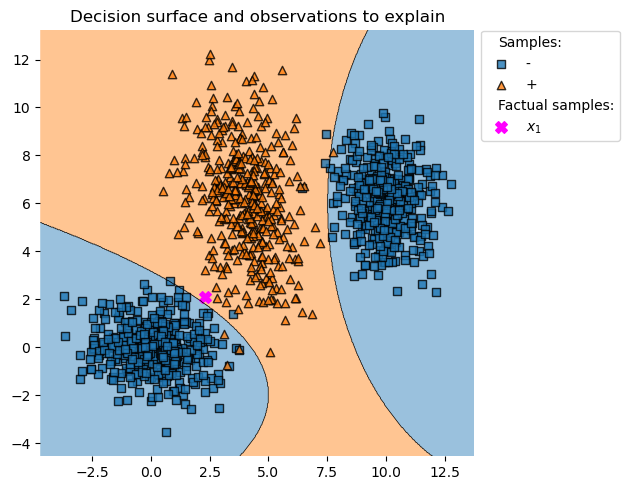

In [11]:
plot = plot_decision_regions(X, y, clf)

factual_colours = ["fuchsia", "yellow", "tab:cyan"]
factual_markers = ["X", "D", "o"]

for i in range(1):
    plot.scatter(point[i, 0], point[i, 1], c=factual_colours[i], marker=factual_markers[i], s=70, label=f"$x_{i + 1}$")


add_multi_legend(plot, titles=["Samples:", "Factual samples:"], titles_pos=[0, 3], changes=[(1, "-"), (2, "+")])
plt.tight_layout()
plt.title("Decision surface and observations to explain")
plt.savefig("imgs/decision_regions.png", dpi=600, bbox_inches='tight')

In [12]:
def plot_decision_boundary(bounds, f, points, ax, fig=None, max_radius=None, vmax=None):
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, points),
                         np.linspace(y_min, y_max, points))

    # Use the model to predict the outcomes on the grid
    Z = f(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    if max_radius is not None:
        Z[Z >= max_radius] = np.nan
    
    print(f"Max is {np.nanmax(Z)}")
    
    if vmax is not None:
        normalizer = Normalize(0, vmax)
    else:
        normalizer = None
    
    # Plot the decision boundary
    cf = ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True, norm=normalizer)
    
    if max_radius is not None:
        z_in = np.zeros_like(Z)
        z_in[np.isnan(Z)] = 1
        ax.contourf(xx, yy, z_in, 3, hatches=['', '/'],  alpha=0.1, colors='none', norm=normalizer)
        
        
    return ax, cf

Max is 0.7310585786300049


/tmp/ipykernel_77387/2176616861.py:22: UserWarning: linewidths is ignored by contourf
  cf = ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True, norm=normalizer)


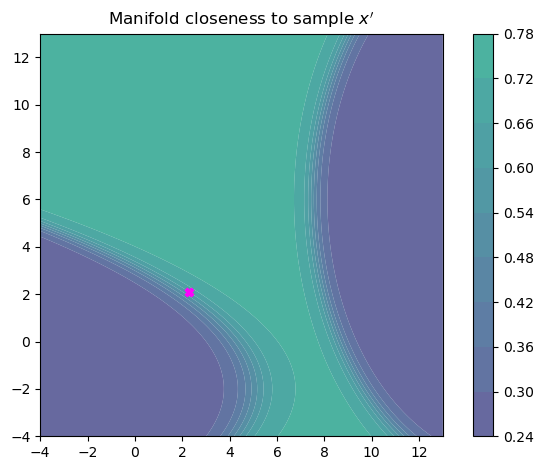

In [13]:
fig, (ax1) = plt.subplots(1, 1, sharey=True, subplot_kw={'aspect': 1})
ax1.set_box_aspect(1)
#ax2.set_box_aspect(1)
#ax3.set_box_aspect(1)


def manifold_closeness(clf, factual):
    factual_prob = clf.predict_proba(factual.reshape(1, -1))
    idx = np.argmax(factual_prob.ravel())
    
    def impl(X):
        return (clf.predict_proba(X))[:, idx]
    return impl

manifold_plot_1_distance = manifold_closeness(clf, point[0, :])
manifold_plot_2_distance = manifold_closeness(clf, point[1, :])
manifold_plot_3_distance = manifold_closeness(clf, point[2, :])

_, cf = plot_decision_boundary([[-4, 13], [-4, 13]], manifold_plot_1_distance, 1000, ax=ax1, vmax=1.34)
#plot_decision_boundary([[-4, 13], [-4, 13]], manifold_plot_2_distance, 1000, ax=ax2)
#plot_decision_boundary([[-4, 13], [-4, 13]], manifold_plot_3_distance, 1000, ax=ax3)


ax1.set_title("Manifold closeness to sample $x'$")
ax1.scatter(point[0, 0], point[0, 1], label="Sample $x'$", marker=factual_markers[0], c=factual_colours[0])

#ax2.set_title("Point 2")
#ax2.scatter(point[1, 0], point[1, 1], c='black')

#ax3.set_title("Point 3")
#ax3.scatter(point[2, 0], point[2, 1], c='black')

#fig.suptitle("Manifold closeness", y=1.1)
#plt.legend(ncol=1, loc='upper left', bbox_to_anchor=(1, 1.015))
fig.colorbar(cf, ax=ax1)
fig.tight_layout()
fig.savefig("imgs/manifold_closeness.png", dpi=600)



Max is 0.9971767350095411
Max is 1.147333975740719


/tmp/ipykernel_77387/2176616861.py:22: UserWarning: linewidths is ignored by contourf
  cf = ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True, norm=normalizer)


Max is 1.4808897906909095


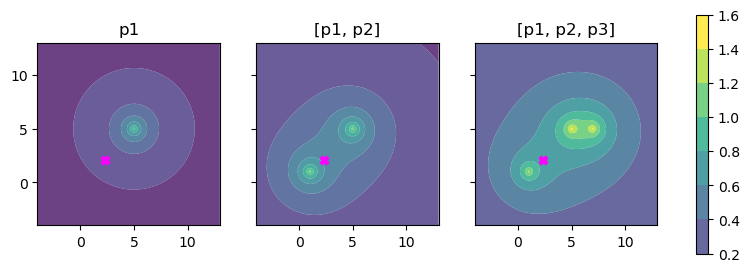

In [23]:
def penalization(p1, p2):
    return 1 / (1 + np.linalg.norm(p1 - p2, axis=1))

def penalization_function(base, points, penalization_f=penalization):
    
    def impl(X):
        acc = 0
        for point in points:
            acc += penalization(X, point)
            
        return acc
    
    return impl


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.1), sharey=True, subplot_kw={'aspect': 1})
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)


penalization_points = np.array([[5, 5], [1, 1], [7, 5]])

diversity_plot_1_function = penalization_function(point[0, :], penalization_points[[0], :])
diversity_plot_2_function = penalization_function(point[1, :], penalization_points[[0, 1], :])
diversity_plot_3_function = penalization_function(point[2, :], penalization_points[[0, 1, 2], :])

vmax=1.49

_, _ = plot_decision_boundary([[-4, 13], [-4, 13]], diversity_plot_1_function, 1000, ax=ax1, vmax=vmax)
_ , _ = plot_decision_boundary([[-4, 13], [-4, 13]], diversity_plot_2_function, 1000, ax=ax2, vmax=vmax)
_ , cf = plot_decision_boundary([[-4, 13], [-4, 13]], diversity_plot_3_function, 1000, ax=ax3, vmax=vmax)


ax1.set_title("p1")
ax1.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])

ax2.set_title("[p1, p2]")
ax2.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])

ax3.set_title("[p1, p2, p3]")
ax3.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])

#fig.suptitle("Diversity", y=1.1)

fig.colorbar(cf, ax=[ax1, ax2, ax3])

fig.savefig("imgs/diversity_function.png", dpi=600)

Max is 21.6


/tmp/ipykernel_77387/2176616861.py:22: UserWarning: linewidths is ignored by contourf
  cf = ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True, norm=normalizer)


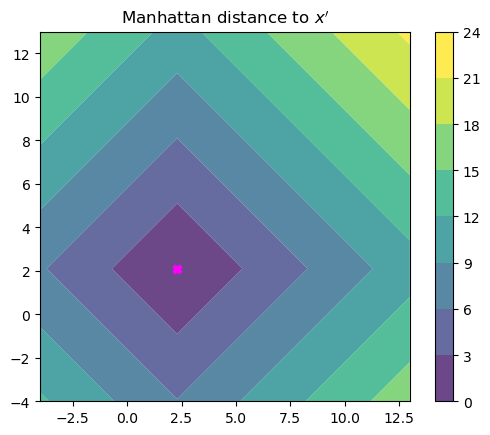

In [15]:
distance_function = lambda x, y: np.linalg.norm(x - y, axis=1, ord=1)


def distance_function_wrapper(base_point, distance=distance_function):
    
    def impl(X):
        return distance(base_point, X)
    
    return impl


fig, (ax1) = plt.subplots(1, 1, sharey=True, subplot_kw={'aspect': 1})
#ax1.set_box_aspect(1)
#ax2.set_box_aspect(1)
#ax3.set_box_aspect(1)

base_plot_1_distance = distance_function_wrapper(point[0, :])
#base_plot_2_distance = distance_function_wrapper(point[1, :])
#base_plot_3_distance = distance_function_wrapper(point[2, :])

vmax = 21.6
_ , cf = plot_decision_boundary([[-4, 13], [-4, 13]], base_plot_1_distance, 1000, ax=ax1, vmax=vmax)
#plot_decision_boundary([[-4, 13], [-4, 13]], base_plot_2_distance, 1000, ax=ax2)
#plot_decision_boundary([[-4, 13], [-4, 13]], base_plot_3_distance, 1000, ax=ax3)


ax1.set_title("Manhattan distance to $x'$")
ax1.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])

#ax2.set_title("$x_2$")
#ax2.scatter(point[1, 0], point[1, 1], c='black')

#ax3.set_title("$x_3$")
#ax3.scatter(point[2, 0], point[2, 1], c='black')

#fig.suptitle("Manhattan distance to point:", y=1.1)
fig.colorbar(cf, ax=[ax1])
#fig.tight_layout()
fig.savefig("imgs/base_distance.png", dpi=600, bbox_inches='tight')


Max is 0.0
Max is 0.0


/tmp/ipykernel_77387/2176616861.py:22: UserWarning: linewidths is ignored by contourf
  cf = ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True, norm=normalizer)


Max is 0.0


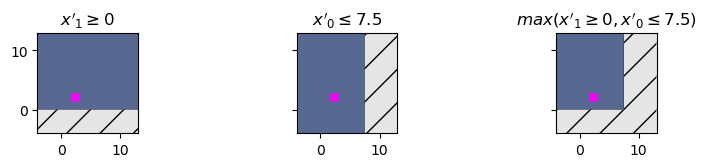

In [20]:
def actionability_wrapper(bounds, feature, penalization):
    
    def impl(X):
        distance = np.zeros(shape=X.shape[0])
        
        if bounds[0] is not None:
            distance[X[:, feature] <= bounds[0]] = penalization
            
        if bounds[1] is not None:
            distance[X[:, feature] >= bounds[1]] = penalization
            
        return distance
    
    return impl



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.1), sharey=True, sharex=True)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)

penalization_value = 10

actionability_plot_1_distance = actionability_wrapper([0, None], 1, penalization_value)
actionability_plot_2_distance = actionability_wrapper([None, 7.5], 0, penalization_value)
actionability_plot_3_distance =  lambda X: np.maximum(actionability_plot_1_distance(X), actionability_plot_2_distance(X))

_ , _ = plot_decision_boundary([[-4, 13], [-4, 13]], actionability_plot_1_distance, 1000, ax=ax1, max_radius=penalization_value)
_ , _ = plot_decision_boundary([[-4, 13], [-4, 13]], actionability_plot_2_distance, 1000, ax=ax2, max_radius=penalization_value)
_ , cf = plot_decision_boundary([[-4, 13], [-4, 13]], actionability_plot_3_distance, 1000, ax=ax3, max_radius=penalization_value)


ax1.set_title("$x'_1 \geq 0$")
ax1.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])

ax2.set_title("$x'_0 \leq 7.5$")
ax2.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])

ax3.set_title("$max (x'_1 \geq 0, x'_0 \leq 7.5)$")
ax3.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])

#fig.suptitle("Actionability examples", y=1.1)
#fig.colorbar(cf, ax=[ax1, ax2, ax3])

fig.savefig("imgs/actionability_example.png", dpi=600)

fig.tight_layout()

In [17]:
def sum_combination(distances):
    
    def impl(X):
        res = 0
        
        for distance in distances:
            res += distance(X)
            
        return res
    
    return impl

def max_combination(distances, radiuses, penalization=10):
    
    def impl(X):
        res = []
        for distance, r in zip(distances, radiuses):
            dists = distance(X) * (penalization / r)
            res.append(dists)
        full_dists = np.column_stack(res)
        max_dist = np.max(full_dists, axis=1)
        return max_dist
    
    return impl

Max is 9.99999686126213


/tmp/ipykernel_77387/2176616861.py:22: UserWarning: linewidths is ignored by contourf
  cf = ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True, norm=normalizer)


Max is 9.99998252886069
Max is 9.999994615115556
Max is 9.991171171171175
Max is 9.991171171171175
Max is 9.991171171171175


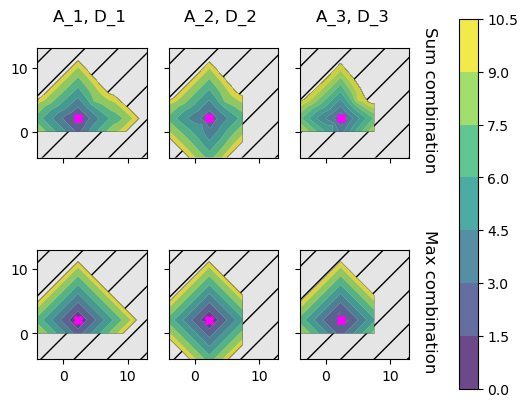

In [21]:
fig, (ax_r1, ax_r2) = plt.subplots(2, 3, sharey=True, sharex=True, subplot_kw={'aspect': 1})
ax11, ax12, ax13 = ax_r1
ax21, ax22, ax23 = ax_r2

diversity_factor = 2

plot_sum_combination_r1 = sum_combination([actionability_plot_1_distance, base_plot_1_distance, lambda X: diversity_factor * diversity_plot_1_function(X), manifold_plot_1_distance])
plot_sum_combination_r2 = sum_combination([actionability_plot_2_distance, base_plot_1_distance, lambda X: diversity_factor * diversity_plot_2_function(X), manifold_plot_1_distance])
plot_sum_combination_r3 = sum_combination([actionability_plot_3_distance, base_plot_1_distance, lambda X: diversity_factor * diversity_plot_3_function(X), manifold_plot_1_distance])

vmax = 10

plot_decision_boundary([[-4, 13], [-4, 13]], plot_sum_combination_r1, 1000, ax=ax11, max_radius=penalization_value, vmax=vmax)
plot_decision_boundary([[-4, 13], [-4, 13]], plot_sum_combination_r2, 1000, ax=ax12, max_radius=penalization_value, vmax=vmax)
plot_decision_boundary([[-4, 13], [-4, 13]], plot_sum_combination_r3, 1000, ax=ax13, max_radius=penalization_value, vmax=vmax)


plot_max_combination_r1 = max_combination([actionability_plot_1_distance, base_plot_1_distance, lambda X: diversity_factor * diversity_plot_1_function(X), manifold_plot_1_distance], [penalization_value, penalization_value, penalization_value, penalization_value], penalization=penalization_value+1)
plot_max_combination_r2 = max_combination([actionability_plot_2_distance, base_plot_1_distance, lambda X: diversity_factor * diversity_plot_2_function(X), manifold_plot_1_distance], [penalization_value, penalization_value, penalization_value, penalization_value], penalization=penalization_value+1)
plot_max_combination_r3 = max_combination([actionability_plot_3_distance, base_plot_1_distance, lambda X: diversity_factor * diversity_plot_3_function(X), manifold_plot_1_distance], [penalization_value, penalization_value, penalization_value, penalization_value], penalization=penalization_value+1)

plot_decision_boundary([[-4, 13], [-4, 13]], plot_max_combination_r1, 1000, ax=ax21, max_radius=penalization_value, vmax=vmax)
plot_decision_boundary([[-4, 13], [-4, 13]], plot_max_combination_r2, 1000, ax=ax22, max_radius=penalization_value, vmax=vmax)
_, cf = plot_decision_boundary([[-4, 13], [-4, 13]], plot_max_combination_r3, 1000, ax=ax23, max_radius=penalization_value, vmax=vmax)


ax13.text = ax13.text(15, 5,"Sum combination", size=12, verticalalignment='center', rotation=270)
ax23.text = ax23.text(15, 5,"Max combination", size=12, verticalalignment='center', rotation=270)


ax11.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])
ax12.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])
ax13.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])
ax21.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])
ax22.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])
ax23.scatter(point[0, 0], point[0, 1], marker=factual_markers[0], c=factual_colours[0])




ax11.set_title("A_1, D_1 \n")
ax12.set_title("A_2, D_2 \n")
ax13.set_title("A_3, D_3 \n")

fig.colorbar(cf, ax=[*ax_r1, *ax_r2], pad=0.1)
#fig.tight_layout()
#fig.suptitle("Combination examples", y=1.1)
fig.savefig("imgs/combination_example_1.png", dpi=600, bbox_inches='tight')

Max is 9.991171171171175


/tmp/ipykernel_77387/2176616861.py:22: UserWarning: linewidths is ignored by contourf
  cf = ax.contourf(xx, yy, Z, alpha=0.8, linewidths = 0.5, antialiased =  True, norm=normalizer)


Max is 9.991171171171175
Max is 9.991171171171175


/tmp/ipykernel_77387/989056538.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


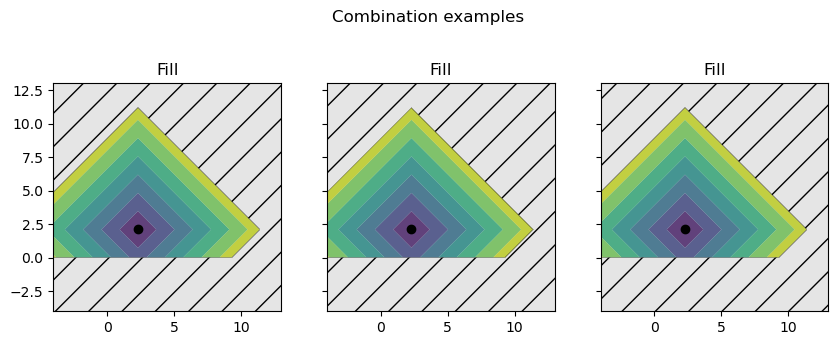

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.1), sharey=True, sharex=True)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)

plot_1_combination = max_combination([actionability_plot_1_distance, base_plot_1_distance, diversity_plot_1_function, manifold_plot_1_distance], 
                                     [penalization_value, penalization_value, penalization_value, penalization_value], penalization=penalization_value+1)
plot_decision_boundary([[-4, 13], [-4, 13]], plot_1_combination, 1000, ax=ax1, max_radius=penalization_value)

plot_decision_boundary([[-4, 13], [-4, 13]], plot_1_combination, 1000, ax=ax2, max_radius=penalization_value)
plot_decision_boundary([[-4, 13], [-4, 13]], plot_1_combination, 1000, ax=ax3, max_radius=penalization_value)

ax1.set_title("Fill")
ax1.scatter(point[0, 0], point[0, 1], c='black')

ax2.set_title("Fill")
ax2.scatter(point[0, 0], point[0, 1], c='black')

ax3.set_title("Fill")
ax3.scatter(point[0, 0], point[0, 1], c='black')


fig.suptitle("Combination examples", y=1.1)
fig.savefig("imgs/max_combination_example.png", dpi=600)
fig.tight_layout()